In [1]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log
## Own python package
from source_microseism import site_effect, open_bathy
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "2.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Production"

# Spatial Extent

In [2]:
# extent
lat_min = -10 # -78 min
lat_max = 50 # 80 max
lon_min = 100 # -180 min
lon_max = 180 # 180 max

extent = [lon_min, lon_max, lat_min, lat_max]

## Bathymetry file 
   The bathymetry (or waterlevel) is necessary to compute the site effect for a given phase.

Two bathymetry grids are available with this notebook: 
- (default) "ww3.07121700.dpt": a 0.5°x0.5° bathymetry file corresponding to WW3 hindcast resolution.

- (```refined_bathymetry = True```) a 1 arcmin resolution ETOPOv2 bathymetry netcdf file.

==> Available here: https://www.ngdc.noaa.gov/thredds/catalog/global/ETOPO2022/60s/60s_bed_elev_netcdf/catalog.html?dataset=globalDatasetScan/ETOPO2022/60s/60s_bed_elev_netcdf/ETOPO_2022_v1_60s_N90W180_bed.nc
- [WARNING] use this refined bathymetry on small grids otherwise memory errors might occur (typically 30° lat x 30° lon)

If you wish to use your own bathymetry file:
- latitude in ° 1D array should be named ```zlat```.
- longitude in ° 1D array should be named ```zlon```.
- depth in meters 2D grid should be named ```dpt1```.

 dpt1 shape  (3600, 4800)


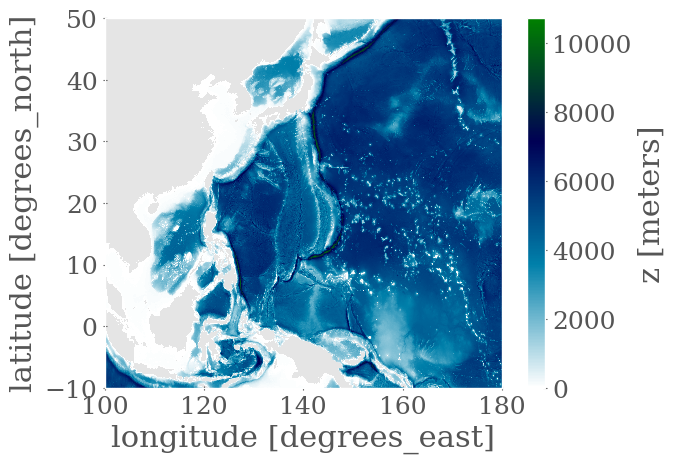

In [3]:
# bathymetry default
file_bathy = "./ww3.07121700.dpt"  #0.5x0.5 degree grid bathymetry
dpt1, zlon, zlat = open_bathy(file_bathy, refined_bathymetry=True, extent=extent)  # load bathymetry, refined_bathymetry = True
                                                                                   # with ETOPOv2 1 arcmin resolution

# Plot
dpt1.plot(cmap='ocean_r')
plt.show()

# Amplification Coefficients 
We compute the amplitude response functions for the normal modes, from Longuet-Higgins (1950). $ C(f, h) = \sum_{i=1}^{4} c_i(f,h)^2 $.
Where h is the water column depth and f the seismic frequency.

For details on the computation see references:
- LONGUET-HIGGINS, Michael Selwyn. A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 1950, vol. 243, no 857, p. 1-35.https://doi-org.insu.bib.cnrs.fr/10.1098/rsta.1950.0012
- GIMBERT, Florent et TSAI, Victor C. Predicting short-period, wind-wave-generated seismic noise in coastal regions. Earth and Planetary Science Letters, 2015, vol. 426, p. 280-292. https://doi-org.insu.bib.cnrs.fr/10.1016/j.epsl.2015.06.017

In [4]:
# Amplification map
f = np.array([0.08203799, 0.0902418, 0.09926598, 0.10919258, 0.12011184, 0.13212304,
                0.14533535, 0.15986888, 0.17585577, 0.19344135, 0.21278548, 0.23406404,
                0.25747046, 0.28321752, 0.3115393,  0.34269324, 0.37696257, 0.41465884,
                0.45612472, 0.50173724, 0.55191094, 0.60710204])
vs_crust = 2.8

print("THIS SHOULD TAKE 20 MINUTES TO RUN")
path = './longuet_higgins.txt'
amplif = site_effect(dpt1, f, zlat, zlon, vs_crust, path)

THIS SHOULD TAKE 5 MINUTES TO RUN


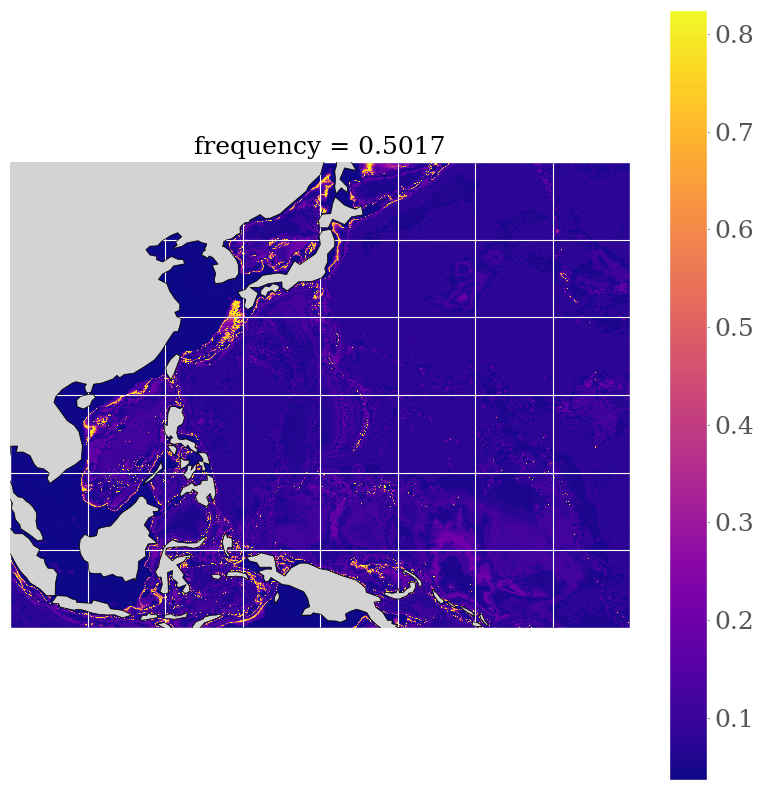

In [5]:
# Plot 
amplif_plot = amplif.sel(frequency= 0.5, method='nearest')
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Amplification coefficient")
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgrey')
amplif_plot.plot(cmap='plasma', transform=ccrs.PlateCarree(), ax=ax)
plt.show()

## Save to netcdf

In [6]:
# Create netCDF 
amplif.to_netcdf('c_custom.nc')